<a href="https://colab.research.google.com/github/reyllama/TTIO/blob/master/07_BackTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modulate

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.autograd import Variable
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [246]:
data = pd.read_csv("/content/drive/My Drive/core_stocks.csv", dtype={'stock_id': str})
data['stock_id'] = data['stock_id'].astype(str)

In [278]:
def data_preparer(n=1, n_epochs=120, lr=0.05, silent=False):
    path = "/content/drive/My Drive/corr{0}.csv".format(n)
    df = pd.read_csv(path)
    df = df.set_index(keys='stock_id')
    df.columns = df.columns.astype(str)
    df.index = df.index.astype(str)

    if n==1:
        st, ed = 1, 121
    elif n==2:
        st, ed = 62, 186
    elif n==3:
        st, ed=124,248
    elif n==4:
        st, ed=186,310
    elif n==5:
        st, ed=248, 368
    elif n==6:
        st, ed=310, 432
    elif n==7:
        st, ed=368,489
    elif n==8:
        st, ed=432, 550
    else:
        print("Too Big A Number")
        return None

    embeddings = get_embeddings(corr_df=df, n_epochs=n_epochs, lr=lr, silent=silent)

    return df, embeddings, st, ed

In [248]:
df, embeddings, st, ed = data_preparer(n=1, n_epochs=120, lr=0.05)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


20th epoch in process
running loss: -754536.5625

40th epoch in process
running loss: -857014.5625

60th epoch in process
running loss: -906195.3125

80th epoch in process
running loss: -962533.75

100th epoch in process
running loss: -1019501.9375

120th epoch in process
running loss: -1062266.625



In [249]:
def get_embeddings(corr_df=df, n_epochs=100, dim=32, lr=0.01, silent=False):
  dtype = torch.FloatTensor
  epochs = n_epochs
  emb_dim = dim
  embeddings = Variable(torch.randn(emb_dim, len(df)).type(dtype), requires_grad=True)
  lr = lr
  optimizer = optim.Adam([embeddings], lr=lr)
  mean = np.abs(df).mean().mean()
  coef = 1/mean # Hyper Parameter 변경
  loss_track = []

  for epoch in range(epochs):
    loss = 0
    for i in range(len(df)):
      v1 = embeddings[:, i].view(emb_dim, -1)
      dist = torch.norm(v1 - embeddings, dim=0).view(len(df), 1)
      corrs = torch.from_numpy(np.abs(coef*np.array(df.iloc[:, i]))-1).view(1, len(df)).type(torch.FloatTensor)
    #   corrs = torch.from_numpy(np.array(df.iloc[:, i])).view(1, len(df)).type(torch.FloatTensor) # rho 교수님 버전
      loss += torch.mm(corrs, dist)/2

    #   v1 = embeddings[:, i].view(-1, emb_dim)
    #   mm = torch.mm(v1, embeddings)
    #   mm[:, i] = torch.zeros(1) # 자기 자신과의 dot product은 0으로 만들어줌. 그렇지 않으면 각각이 다 0 벡터가 될 우려
    #   corrs = torch.from_numpy(coef*np.array(df.iloc[:, i])).view(len(df), 1).type(torch.FloatTensor)
    #   loss += torch.mm(mm, corrs)

    loss_track.append(loss.item())
    if not silent:
        if (epoch+1) % 20 == 0:
            print("{0}th epoch in process".format(epoch+1))
            print('running loss: {}'.format(loss.item()))
            print()

    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()

    with torch.no_grad():
      for element in embeddings:
        element.clamp_(0,1)

  return embeddings

In [250]:
!pip install ta
import ta

def bias(close=None, m=7):
  return close - close.rolling(m).mean()

def preprocessing(data=data, start=125, end=125+62, corr_df = df):

  data['stock_id'] = data['stock_id'].astype(str)
  data['year'] = data['date'].apply(lambda x: int(x[0:4]))
  data['month'] = data['date'].apply(lambda x: int(x[5:7]))

  data = data[(data['date_index']<=end)&(data['date_index']>=start)]
  data = data[data['stock_id'].isin(df.columns)]

  data['KLength'] = data['closing_price'] - data['opening_price']
  data['KUpperLength'] = data['highest_price'] - data[['opening_price', 'closing_price']].max(axis=1)
  data['temp'] = data['opening_price']-data['lowest_price']
  data['KLowerLength'] = data[['closing_price', 'temp']].min(axis=1)
  data['return'] = data['closing_price'].diff()
  data = data.drop(columns=['temp'])

  data['EMA'] = ta.trend.ema_indicator(close=data['closing_price'])
  data['MACD'] = ta.trend.macd(close=data['closing_price'])
  data['ROC'] = ta.momentum.roc(close=data['closing_price'])
  data['BIAS'] = bias(data['closing_price'])
  

  return data

In [251]:
def rescale_factor(data=data, indicator='KLength', lr=0.005, n_epochs=3000, embeddings=None):
  KL = data.pivot(index='date', columns='stock_id', values=indicator)
  R = data.pivot(index='date', columns='stock_id', values='return')

  if indicator in ['KLength', 'KUpperLength', 'KLowerLength']:
    KL = KL.iloc[:-1, ]
    R = R.iloc[1:, ]
  elif indicator == 'EMA':
    KL = KL.iloc[11:-1, ]
    R = R.iloc[12:, ]
  elif indicator == 'MACD':
    KL = KL.iloc[25:-1, ]
    R = R.iloc[26:, ]
  elif indicator == 'ROC':
    KL = KL.iloc[12:-1, ]
    R = R.iloc[13:, ]
  elif indicator == 'BIAS':
    KL = KL.iloc[6:-1, ]
    R = R.iloc[7:, ]
  else:
    print('Unknown Indicator!')
    return None

  dtype = torch.FloatTensor
  weights = Variable(torch.randn(1, 32).type(dtype), requires_grad=True)
  lr = lr
  optimizer = optim.Adam([weights], lr=lr)
  epochs = n_epochs
  indic = np.array(KL)
  returns = np.array(R)

  for epoch in range(epochs):
    loss = 0

    rescale_fc = torch.exp(torch.mm(weights, embeddings)) / torch.sum(torch.exp(torch.mm(weights, embeddings)))
    opt_ind = torch.from_numpy(indic) * rescale_fc # element-wise
    mean_ind = torch.mean(opt_ind, axis=0)
    mean_ret = torch.mean(torch.from_numpy(returns), axis=0)

    vx = opt_ind - mean_ind
    vy = torch.from_numpy(returns) - mean_ret
    loss = -torch.abs(torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))))

    if (epoch+1) % 1000 == 0:
      print("{0}th epoch in process".format(epoch+1))

    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()

    with torch.no_grad():
      for weight in weights:
        weight.clamp_(0,1)

  return rescale_fc

In [270]:
def comprehensive_backtest(data=data, corr_df=df, start=st, end=ed, window=62, embeddings=embeddings, e=5, silent=False):
    
    train_df = preprocessing(data=data, corr_df=corr_df, start=start, end=end)
    first_term = preprocessing(data=data, corr_df=corr_df, start=start, end=end+window)
    indicators=['EMA', 'MACD', 'KLength', 'KUpperLength', 'KLowerLength', 'ROC', 'BIAS']
    result = dict()
    result['K'], result['indicator'], result['raw'], result['scaled'] = [], [], [], []

    for k in range(2, 11):


        for indicator in indicators:

            j, s, = 0, 0
            rescale_fc = rescale_factor(indicator=indicator, data=train_df, embeddings=embeddings, n_epochs=80, lr=0.05)

            for _ in range(e):

                cap = 1e7
                base_cap = 1e7
                a,b = [1e7], [1e7]

                for day in range(end, end+window-1):

                    base_top10 = np.array(first_term[first_term['date_index']==day][indicator]).T.argsort()[-k:][::-1]
                    base_top10_close = first_term[first_term['date_index']==day+1].iloc[base_top10, :]['closing_price']
                    base_top10_open = first_term[first_term['date_index']==day+1].iloc[base_top10, :]['opening_price']
                    base_cap += ((base_top10_close*0.997 - base_top10_open)/base_top10_open*base_cap/k).sum()
                    a.append(base_cap)

                    #Parallel Universe
                    temp = rescale_fc.detach().numpy() * np.array(first_term[first_term['date_index']==day][indicator]).T # elementwise
                    top10 = temp.squeeze().argsort()[-k:][::-1]
                    top10_close = first_term[first_term['date_index']==day+1].iloc[top10, :]['closing_price']
                    top10_open = first_term[first_term['date_index']==day+1].iloc[top10, :]['opening_price']
                    # print((top10_close*0.997 - top10_open)/top10_open*0.1*cap)
                    cap += ((top10_close*0.997 - top10_open)/top10_open*cap/k).sum()
                    b.append(cap)

                j += a[-1]
                s += b[-1]
            if not silent:
                print("Top {0} 기준 Raw 수익과 Rescaled 수익은 각각 {2:.2f} // {3:.2f} ({1})".format(k, indicator, j/e, s/e))

            result['K'].append(k)
            result['indicator'].append(indicator)
            result['raw'].append(j/e)
            result['scaled'].append(s/e)

    return result

In [279]:
output = pd.DataFrame(columns=['K', 'indicator', 'raw', 'scaled'])
output

,K,indicator,raw,scaled


In [280]:
for n_ in range(1, 9):

    df, embeddings, st, ed = data_preparer(n=n_, n_epochs=120, lr=0.05, silent=True)
    result_dict = comprehensive_backtest(data=data, corr_df=df, start=st, end=ed, window=62, embeddings=embeddings, e=5, silent=True)
    output = pd.concat([output, pd.DataFrame(data=result_dict)])
output

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


20th epoch in process
running loss: -905974.4375

40th epoch in process
running loss: -1033683.6875

60th epoch in process
running loss: -1108524.125

80th epoch in process
running loss: -1199952.375

100th epoch in process
running loss: -1245341.75

120th epoch in process
running loss: -1268586.5



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


20th epoch in process
running loss: -540580.8125

40th epoch in process
running loss: -615271.25

60th epoch in process
running loss: -655879.8125

80th epoch in process
running loss: -709052.8125

100th epoch in process
running loss: -745358.375

120th epoch in process
running loss: -766083.4375



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


20th epoch in process
running loss: -627642.8125

40th epoch in process
running loss: -718436.375

60th epoch in process
running loss: -775996.0625

80th epoch in process
running loss: -842914.4375

100th epoch in process
running loss: -871292.6875

120th epoch in process
running loss: -885752.3125



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


20th epoch in process
running loss: -665680.625

40th epoch in process
running loss: -758477.375

60th epoch in process
running loss: -812566.5625

80th epoch in process
running loss: -889573.625

100th epoch in process
running loss: -945435.25

120th epoch in process
running loss: -962777.9375



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


20th epoch in process
running loss: -434295.96875

40th epoch in process
running loss: -495276.875

60th epoch in process
running loss: -530512.0

80th epoch in process
running loss: -573292.9375

100th epoch in process
running loss: -598403.0

120th epoch in process
running loss: -609089.3125



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


20th epoch in process
running loss: -533943.25

40th epoch in process
running loss: -606466.5

60th epoch in process
running loss: -645652.9375

80th epoch in process
running loss: -695700.9375

100th epoch in process
running loss: -725462.375

120th epoch in process
running loss: -745981.5



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


20th epoch in process
running loss: -508516.28125

40th epoch in process
running loss: -587005.625

60th epoch in process
running loss: -641751.3125

80th epoch in process
running loss: -702303.0

100th epoch in process
running loss: -728485.625

120th epoch in process
running loss: -739539.9375



,K,indicator,raw,scaled
0,2,EMA,1.032066e+07,7.814462e+06
1,2,MACD,6.152803e+06,8.461164e+06
2,2,KLength,8.263584e+06,6.157101e+06
3,2,KUpperLength,7.244848e+06,7.353240e+06
4,2,KLowerLength,8.510831e+06,7.799338e+06
...,...,...,...,...
58,10,KLength,5.839165e+06,7.390895e+06
59,10,KUpperLength,7.188938e+06,7.462902e+06
60,10,KLowerLength,9.082560e+06,7.300929e+06
61,10,ROC,7.399484e+06,7.777703e+06


In [281]:
df, embeddings, st, ed = data_preparer(n=1, n_epochs=120, lr=0.05)
result_dict = comprehensive_backtest(data=data, corr_df=df, start=st, end=ed, window=62, embeddings=embeddings, e=5, silent=True)
output = pd.concat([pd.DataFrame(data=result_dict), output])
output

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


20th epoch in process
running loss: -516099.78125

40th epoch in process
running loss: -594079.4375

60th epoch in process
running loss: -654065.8125

80th epoch in process
running loss: -720266.3125

100th epoch in process
running loss: -746321.625

120th epoch in process
running loss: -753611.625



,K,indicator,raw,scaled
0,2,EMA,9.841349e+06,8.204562e+06
1,2,MACD,9.218793e+06,8.639925e+06
2,2,KLength,7.920095e+06,7.266897e+06
3,2,KUpperLength,8.623466e+06,9.691628e+06
4,2,KLowerLength,7.611521e+06,7.811540e+06
...,...,...,...,...
58,10,KLength,5.839165e+06,7.390895e+06
59,10,KUpperLength,7.188938e+06,7.462902e+06
60,10,KLowerLength,9.082560e+06,7.300929e+06
61,10,ROC,7.399484e+06,7.777703e+06


In [282]:
output.to_csv('corr_output.csv', index=False)

In [284]:
output = output.reset_index(drop=True)
output

,K,indicator,raw,scaled
0,2,EMA,9.841349e+06,8.204562e+06
1,2,MACD,9.218793e+06,8.639925e+06
2,2,KLength,7.920095e+06,7.266897e+06
3,2,KUpperLength,8.623466e+06,9.691628e+06
4,2,KLowerLength,7.611521e+06,7.811540e+06
...,...,...,...,...
499,10,KLength,5.839165e+06,7.390895e+06
500,10,KUpperLength,7.188938e+06,7.462902e+06
501,10,KLowerLength,9.082560e+06,7.300929e+06
502,10,ROC,7.399484e+06,7.777703e+06


In [287]:
output['diff'] = output['scaled'] - output['raw']

In [288]:
output.groupby('K')[['scaled', 'raw', 'diff']].mean()

,scaled,raw,diff
K,,,
2,7.391624e+06,7.920106e+06,-528481.519133
3,7.704454e+06,7.757401e+06,-52947.691021
4,7.797532e+06,7.738031e+06,59500.549041
5,7.866774e+06,7.693474e+06,173300.094930
6,7.654959e+06,7.715342e+06,-60382.739740
7,7.656316e+06,7.690072e+06,-33755.721431
8,7.662479e+06,7.684313e+06,-21834.034419
9,7.597107e+06,7.634245e+06,-37138.343381
10,7.572892e+06,7.672283e+06,-99390.395573


In [289]:
jj = pd.read_csv('/content/drive/My Drive/cov_output.csv')
jj.head()

,K,indicator,raw,scaled
0,2,EMA,9.841349e+06,1.019639e+07
1,2,MACD,9.218793e+06,5.890534e+06
2,2,KLength,7.920095e+06,7.418756e+06
3,2,KUpperLength,8.623466e+06,8.733119e+06
4,2,KLowerLength,7.611521e+06,6.880143e+06


In [290]:
jj['diff'] = jj['scaled'] - jj['raw']
jj.groupby('K')[['scaled', 'raw', 'diff']].mean()

,scaled,raw,diff
K,,,
2,7.118897e+06,7.735347e+06,-616449.311321
3,7.047953e+06,7.450483e+06,-402530.710682
4,7.144857e+06,7.308990e+06,-164132.992955
5,7.305847e+06,7.268670e+06,37176.337714
6,7.367586e+06,7.350424e+06,17161.913825
7,7.340558e+06,7.364809e+06,-24251.081574
8,7.178778e+06,7.495104e+06,-316325.686816
9,7.255124e+06,7.458473e+06,-203348.909039
10,7.299954e+06,7.537303e+06,-237348.735949


## 지금까지 정리

- 2016년~2017년 2년짜리 Back Testing
- 6개월로 임베딩 및 Rescale Factor 산정하고, 이후 3개월 동안 매일매일 Top K개 주식 시가에 구매, 종가에 판매, 0.3% 수수료 포함
- Corr 기준, Loss = |c*rho - 1|x||v_i - v_j||, K=5가 가장 좋은 성능

In [218]:
def backtest(data=data, corr_df=df, indicator='EMA', start=1, end=121, window=62, embeddings=embeddings):
    cap = 1e7
    base_cap = 1e7
    a,b = [1e7], [1e7]

    train_df = preprocessing(data=data, corr_df=corr_df, start=start, end=end)
    rescale_fc = rescale_factor(indicator=indicator, data=train_df, embeddings=embeddings, n_epochs=80, lr=0.05)

    first_term = preprocessing(data=data, corr_df=corr_df, start=start, end=end+window)

    for day in range(end, end+window-1):

        base_top10 = np.array(first_term[first_term['date_index']==day][indicator]).T.argsort()[-10:][::-1]
        base_top10_close = first_term[first_term['date_index']==day+1].iloc[base_top10, :]['closing_price']
        base_top10_open = first_term[first_term['date_index']==day+1].iloc[base_top10, :]['opening_price']
        base_cap += ((base_top10_close*0.997 - base_top10_open)/base_top10_open*0.1*base_cap).sum()
        a.append(base_cap)

        #Parallel Universe
        temp = rescale_fc.detach().numpy() * np.array(first_term[first_term['date_index']==day][indicator]).T # elementwise
        top10 = temp.squeeze().argsort()[-10:][::-1]
        top10_close = first_term[first_term['date_index']==day+1].iloc[top10, :]['closing_price']
        top10_open = first_term[first_term['date_index']==day+1].iloc[top10, :]['opening_price']
        # print((top10_close*0.997 - top10_open)/top10_open*0.1*cap)
        cap += ((top10_close*0.997 - top10_open)/top10_open*0.1*cap).sum()
        b.append(cap)


        if base_cap * cap < 0:
            print("Someone went bankrupt")
            break

    return a,b

# 121일 까지로 embedding, weights 학습
# 122알~183일까지 각 rescaled indicator 값 구함
# 그날그날 가장 높은 값을 보이는 k 개 종목 시가로 구입, 종가로 매각
# 62일동안 이 작업 진행

In [231]:
st = 432
ed = 550

In [232]:
j, k, = 0, 0
e = 5
for _ in range(e):
    s, t = backtest(data=data, corr_df=df, indicator='EMA', start=st, end=ed, window=62, embeddings=embeddings)
    j += s[-1]
    k += t[-1]
print("3개월 후 투자실적: Raw: {0:.2f} // Scaled: {1:.2f}".format(j/e, k/e))

j, k, = 0, 0
e = 5
for _ in range(e):
    s, t = backtest(data=data, corr_df=df, indicator='MACD', start=st, end=ed, window=62, embeddings=embeddings)
    j += s[-1]
    k += t[-1]
print("3개월 후 투자실적: Raw: {0:.2f} // Scaled: {1:.2f}".format(j/e, k/e))

j, k, = 0, 0
# e = 10
for _ in range(e):
    s, t = backtest(data=data, corr_df=df, indicator='KLength', start=st, end=ed, window=62, embeddings=embeddings)
    j += s[-1]
    k += t[-1]
print("3개월 후 투자실적: Raw: {0:.2f} // Scaled: {1:.2f}".format(j/e, k/e))

j, k, = 0, 0
# e = 10
for _ in range(e):
    s, t = backtest(data=data, corr_df=df, indicator='KUpperLength', start=st, end=ed, window=62, embeddings=embeddings)
    j += s[-1]
    k += t[-1]
print("3개월 후 투자실적: Raw: {0:.2f} // Scaled: {1:.2f}".format(j/e, k/e))

j, k, = 0, 0
# e = 10
for _ in range(e):
    s, t = backtest(data=data, corr_df=df, indicator='KLowerLength', start=st, end=ed, window=62, embeddings=embeddings)
    j += s[-1]
    k += t[-1]
print("3개월 후 투자실적: Raw: {0:.2f} // Scaled: {1:.2f}".format(j/e, k/e))

j, k, = 0, 0
# e = 10
for _ in range(e):
    s, t = backtest(data=data, corr_df=df, indicator='ROC', start=st, end=ed, window=62, embeddings=embeddings)
    j += s[-1]
    k += t[-1]
print("3개월 후 투자실적: Raw: {0:.2f} // Scaled: {1:.2f}".format(j/e, k/e))

j, k, = 0, 0
# e = 10
for _ in range(e):
    s, t = backtest(data=data, corr_df=df, indicator='BIAS', start=st, end=ed, window=62, embeddings=embeddings)
    j += s[-1]
    k += t[-1]
print("3개월 후 투자실적: Raw: {0:.2f} // Scaled: {1:.2f}".format(j/e, k/e))

3개월 후 투자실적: Raw: 8387658.63 // Scaled: 8787399.35
3개월 후 투자실적: Raw: 8888402.38 // Scaled: 9134411.18
3개월 후 투자실적: Raw: 5839164.55 // Scaled: 5961182.57
3개월 후 투자실적: Raw: 7188937.84 // Scaled: 7475994.46
3개월 후 투자실적: Raw: 9082560.39 // Scaled: 7382440.25
3개월 후 투자실적: Raw: 7399483.91 // Scaled: 6973793.80
3개월 후 투자실적: Raw: 6149630.81 // Scaled: 7229333.69


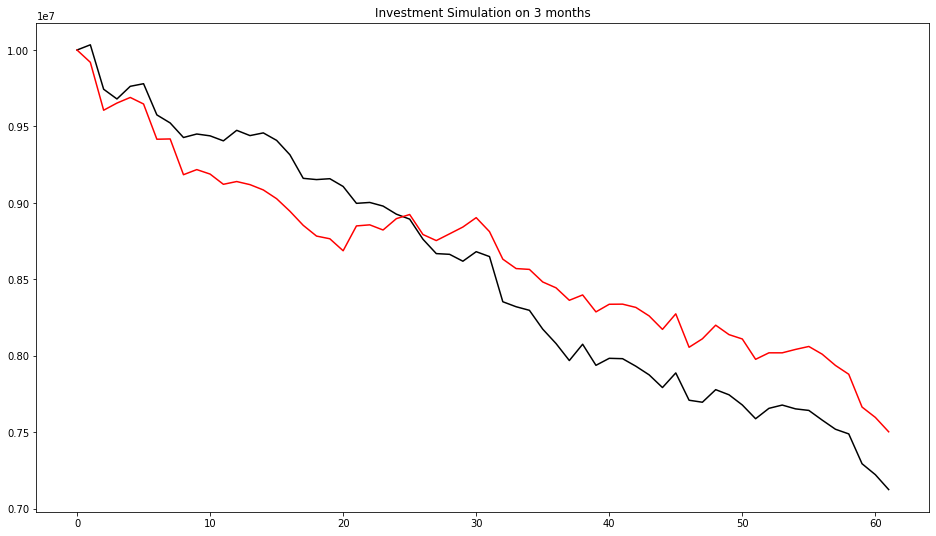

In [168]:
plt.figure(figsize=(16,9))
plt.plot(list(range(62)), s, color='k')
plt.plot(list(range(62)), t, color='red')
plt.title("Investment Simulation on 3 months")
plt.show()